In [14]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "3"

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)
import warnings
import joblib
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Starting BERT Model Development...")
print(f"💻 Using device: {device}")

🚀 Starting BERT Model Development...
💻 Using device: cpu


In [15]:
print("📊 Loading cleaned data from Member 1...")

try:
    train_df = pd.read_csv('../data/train_clean.csv')
    test_df = pd.read_csv('../data/test_clean.csv')
    valid_df = pd.read_csv('../data/valid_clean.csv')
    
    print("✅ Data loaded successfully!")
    print(f"Training: {len(train_df)} samples")
    print(f"Test: {len(test_df)} samples")
    print(f"Validation: {len(valid_df)} samples")
    
except FileNotFoundError:
    print("❌ Cleaned data not found!")
    print("Please run Member 1's notebook first (01_data_cleaning.ipynb)")
    exit()

# For demonstration and speed, we'll use a subset of data
# In production, you can use the full dataset
SAMPLE_SIZE = 2000  # Adjust based on your computer's capability
TEST_SIZE = 400

print(f"\n⚡ Using subset for faster training:")
print(f"   Training subset: {SAMPLE_SIZE} samples")
print(f"   Test subset: {TEST_SIZE} samples")

# Sample data (stratified to maintain label balance)
train_sample = train_df.groupby('label_binary').apply(
    lambda x: x.sample(min(len(x), SAMPLE_SIZE//2), random_state=42)
).reset_index(drop=True)

test_sample = test_df.groupby('label_binary').apply(
    lambda x: x.sample(min(len(x), TEST_SIZE//2), random_state=42)
).reset_index(drop=True)

print(f"✅ Sample created - Train: {len(train_sample)}, Test: {len(test_sample)}")

📊 Loading cleaned data from Member 1...
✅ Data loaded successfully!
Training: 10240 samples
Test: 1267 samples
Validation: 1284 samples

⚡ Using subset for faster training:
   Training subset: 2000 samples
   Test subset: 400 samples
✅ Sample created - Train: 2000, Test: 400


In [16]:
print("\n🤖 INITIALIZING BERT MODEL...")

# Load pre-trained DistilBERT (faster than full BERT)
model_name = 'distilbert-base-uncased'

print("📥 Loading tokenizer and model...")
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device
model.to(device)

print("✅ BERT model initialized successfully!")
print(f"   Model: {model_name}")
print(f"   Device: {device}")


🤖 INITIALIZING BERT MODEL...
📥 Loading tokenizer and model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERT model initialized successfully!
   Model: distilbert-base-uncased
   Device: cpu


In [17]:
print("\n🔤 TOKENIZING TEXT DATA...")

def tokenize_data(texts, labels, max_length=128):
    """
    Tokenize text data for BERT input
    """
    print(f"  🔄 Tokenizing {len(texts)} texts...")
    
    # Tokenize texts
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    return encodings, torch.tensor(labels.values)

# Tokenize training data
train_texts = train_sample['clean_statement'].fillna('')
train_labels = train_sample['label_binary']

train_encodings, train_labels_tensor = tokenize_data(train_texts, train_labels)

# Tokenize test data  
test_texts = test_sample['clean_statement'].fillna('')
test_labels = test_sample['label_binary']

test_encodings, test_labels_tensor = tokenize_data(test_texts, test_labels)

print("✅ Tokenization complete!")
print(f"   Max sequence length: 128")
print(f"   Training tokens shape: {train_encodings['input_ids'].shape}")
print(f"   Test tokens shape: {test_encodings['input_ids'].shape}")


🔤 TOKENIZING TEXT DATA...
  🔄 Tokenizing 2000 texts...
  🔄 Tokenizing 400 texts...
✅ Tokenization complete!
   Max sequence length: 128
   Training tokens shape: torch.Size([2000, 66])
   Test tokens shape: torch.Size([400, 128])


In [18]:
class NewsDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for BERT training
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
print("📦 Creating PyTorch datasets...")
train_dataset = NewsDataset(train_encodings, train_labels_tensor)
test_dataset = NewsDataset(test_encodings, test_labels_tensor)

print("✅ Datasets created successfully!")

📦 Creating PyTorch datasets...
✅ Datasets created successfully!


In [19]:
print("\n⚙ CONFIGURING TRAINING PARAMETERS...")

# Create models directory
os.makedirs('../models', exist_ok=True)
os.makedirs('../models/saved_bert_model', exist_ok=True)

# Training arguments - UPDATED for newer Transformers version
training_args = TrainingArguments(
    output_dir='../models/bert_results',
    num_train_epochs=3,                 # Number of training epochs
    per_device_train_batch_size=8,      # Batch size (reduce if out of memory)
    per_device_eval_batch_size=16,      # Evaluation batch size
    warmup_steps=100,                   # Warmup steps for learning rate
    weight_decay=0.01,                  # Weight decay for regularization
    logging_dir='../models/bert_logs',  # Directory for storing logs
    logging_steps=50,                   # Log every 50 steps
    eval_strategy="steps",              # CHANGED: evaluation_strategy → eval_strategy
    eval_steps=100,                     # Evaluation frequency
    save_strategy="steps",              # Save model every save_steps
    save_steps=200,                     # Save frequency
    load_best_model_at_end=True,        # Load best model at end
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to=None,                     # Disable wandb logging
    save_total_limit=2,                 # Keep only 2 best models
    seed=42                             # For reproducibility
)

print("✅ Training configuration set!")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Device: {device}")


⚙ CONFIGURING TRAINING PARAMETERS...
✅ Training configuration set!
   Epochs: 3
   Batch size: 8
   Device: cpu


In [7]:
try:
    import tensorflow as tf
    if not hasattr(tf, 'random'):
        import tensorflow._api.v2.random as tf_random
        tf.random = tf_random
except ImportError:
    pass

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

def compute_metrics(eval_pred):
    """
    Compute metrics for evaluation
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("\n🎯 INITIALIZING TRAINER...")

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✅ Trainer initialized successfully!")


🎯 INITIALIZING TRAINER...
✅ Trainer initialized successfully!


In [8]:
print("\n🚀 STARTING BERT TRAINING...")
print("⏰ This may take 10-30 minutes depending on your hardware...")

try:
    # Start training
    training_results = trainer.train()
    
    print("✅ Training completed successfully!")
    print(f"   Final training loss: {training_results.training_loss:.4f}")
    
    # Evaluate on test set
    print("\n📊 Evaluating on test set...")
    eval_results = trainer.evaluate(eval_dataset=test_dataset)
    
    print("✅ Evaluation complete!")
    for metric, value in eval_results.items():
        if 'eval_' in metric:
            print(f"   {metric.replace('eval_', '').title()}: {value:.3f}")

except Exception as e:
    print(f"❌ Training failed: {str(e)}")
    print("💡 Try reducing batch size or sample size if out of memory")
    print("   You can also use CPU-only training by setting device='cpu'")


🚀 STARTING BERT TRAINING...
⏰ This may take 10-30 minutes depending on your hardware...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.689700,0.686828,0.510000,0.552632,0.510000,0.385580
200,0.677000,0.681283,0.567500,0.570771,0.567500,0.562443
300,0.664400,0.681836,0.572500,0.573472,0.572500,0.571082
400,0.622400,0.689164,0.597500,0.598807,0.597500,0.596165
500,0.602800,0.702249,0.610000,0.610397,0.610000,0.609649
600,0.355500,0.882805,0.620000,0.625000,0.620000,0.616162
700,0.370800,0.902345,0.597500,0.597561,0.597500,0.597437


✅ Training completed successfully!
   Final training loss: 0.5616

📊 Evaluating on test set...


✅ Evaluation complete!
   Loss: 0.883
   Accuracy: 0.620
   Precision: 0.625
   Recall: 0.620
   F1: 0.616
   Runtime: 27.966
   Samples_Per_Second: 14.303
   Steps_Per_Second: 0.894


In [9]:
print("\n💾 SAVING BERT MODEL...")

# Save model and tokenizer
model.save_pretrained('../models/saved_bert_model')
tokenizer.save_pretrained('../models/saved_bert_model')

print("✅ BERT model saved successfully!")
print("📁 Files saved:")
print("   - ../models/saved_bert_model/ (directory)")
print("   - Model config, weights, and tokenizer")


💾 SAVING BERT MODEL...
✅ BERT model saved successfully!
📁 Files saved:
   - ../models/saved_bert_model/ (directory)
   - Model config, weights, and tokenizer


In [10]:
print("\n🧪 TESTING BERT MODEL...")

def predict_with_bert(text, model=None, tokenizer=None):
    """
    Make prediction using trained BERT model
    """
    if model is None or tokenizer is None:
        print("Loading saved model...")
        model = DistilBertForSequenceClassification.from_pretrained('../models/saved_bert_model')
        tokenizer = DistilBertTokenizer.from_pretrained('../models/saved_bert_model')
        model.to(device)
    
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    )
    
    # Move to device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions.max().item()
    
    return {
        'prediction': 'Real' if predicted_class == 1 else 'Fake',
        'confidence': confidence,
        'probabilities': {
            'Fake': predictions[0][0].item(),
            'Real': predictions[0][1].item()
        }
    }

# Test with sample statements
test_statements = [
    "The President announced new infrastructure spending today.",
    "Scientists have proven that the Earth is actually flat!",
    "Stock markets reached record highs following positive earnings reports.",
    "Breaking: Aliens have invaded Earth and are demanding pizza!"
]

print("\n🧪 TESTING BERT WITH SAMPLE STATEMENTS:")
print("="*70)

for i, statement in enumerate(test_statements, 1):
    try:
        result = predict_with_bert(statement, model, tokenizer)
        print(f"\n📰 Test {i}:")
        print(f"   Statement: {statement}")
        print(f"   🤖 BERT Prediction: {result['prediction']}")
        print(f"   📊 Confidence: {result['confidence']:.3f}")
        print(f"   🔴 Fake probability: {result['probabilities']['Fake']:.3f}")
        print(f"   🟢 Real probability: {result['probabilities']['Real']:.3f}")
    except Exception as e:
        print(f"❌ Error testing statement {i}: {str(e)}")


🧪 TESTING BERT MODEL...

🧪 TESTING BERT WITH SAMPLE STATEMENTS:

📰 Test 1:
   Statement: The President announced new infrastructure spending today.
   🤖 BERT Prediction: Fake
   📊 Confidence: 0.809
   🔴 Fake probability: 0.809
   🟢 Real probability: 0.191

📰 Test 2:
   Statement: Scientists have proven that the Earth is actually flat!
   🤖 BERT Prediction: Fake
   📊 Confidence: 0.931
   🔴 Fake probability: 0.931
   🟢 Real probability: 0.069

📰 Test 3:
   Statement: Stock markets reached record highs following positive earnings reports.
   🤖 BERT Prediction: Real
   📊 Confidence: 0.939
   🔴 Fake probability: 0.061
   🟢 Real probability: 0.939

📰 Test 4:
   Statement: Breaking: Aliens have invaded Earth and are demanding pizza!
   🤖 BERT Prediction: Fake
   📊 Confidence: 0.951
   🔴 Fake probability: 0.951
   🟢 Real probability: 0.049


In [11]:
print("\n📈 BATCH PREDICTION ANALYSIS...")

# Get predictions for entire test set
def get_bert_predictions(dataset, model, batch_size=16):
    """
    Get predictions for entire dataset
    """
    model.eval()
    all_predictions = []
    all_probabilities = []
    
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    print(f"🔄 Processing {len(dataset)} samples in batches of {batch_size}...")
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            # Move batch to device
            batch = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            
            # Get model outputs
            outputs = model(**batch)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            
            all_predictions.extend(torch.argmax(predictions, dim=-1).cpu().numpy())
            all_probabilities.extend(predictions.cpu().numpy())
            
            if (i + 1) % 10 == 0:
                print(f"  📊 Processed {(i + 1) * batch_size} samples...")
    
    return np.array(all_predictions), np.array(all_probabilities)

try:
    # Get BERT predictions
    bert_predictions, bert_probabilities = get_bert_predictions(test_dataset, model)
    
    # Calculate metrics
    bert_accuracy = accuracy_score(test_labels_tensor.cpu().numpy(), bert_predictions)
    
    print(f"\n✅ BERT Model Performance:")
    print(f"   Test Accuracy: {bert_accuracy:.3f}")
    
    # Detailed classification report
    print(f"\n📊 Detailed Classification Report:")
    print(classification_report(test_labels_tensor.cpu().numpy(), bert_predictions, 
                              target_names=['Fake', 'Real']))

except Exception as e:
    print(f"❌ Error in batch prediction: {str(e)}")
    print("💡 Try reducing batch_size or sample_size")


📈 BATCH PREDICTION ANALYSIS...
🔄 Processing 400 samples in batches of 16...
  📊 Processed 160 samples...
  📊 Processed 320 samples...

✅ BERT Model Performance:
   Test Accuracy: 0.620

📊 Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       0.65      0.52      0.58       200
        Real       0.60      0.72      0.65       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400




📊 CREATING VISUALIZATIONS...


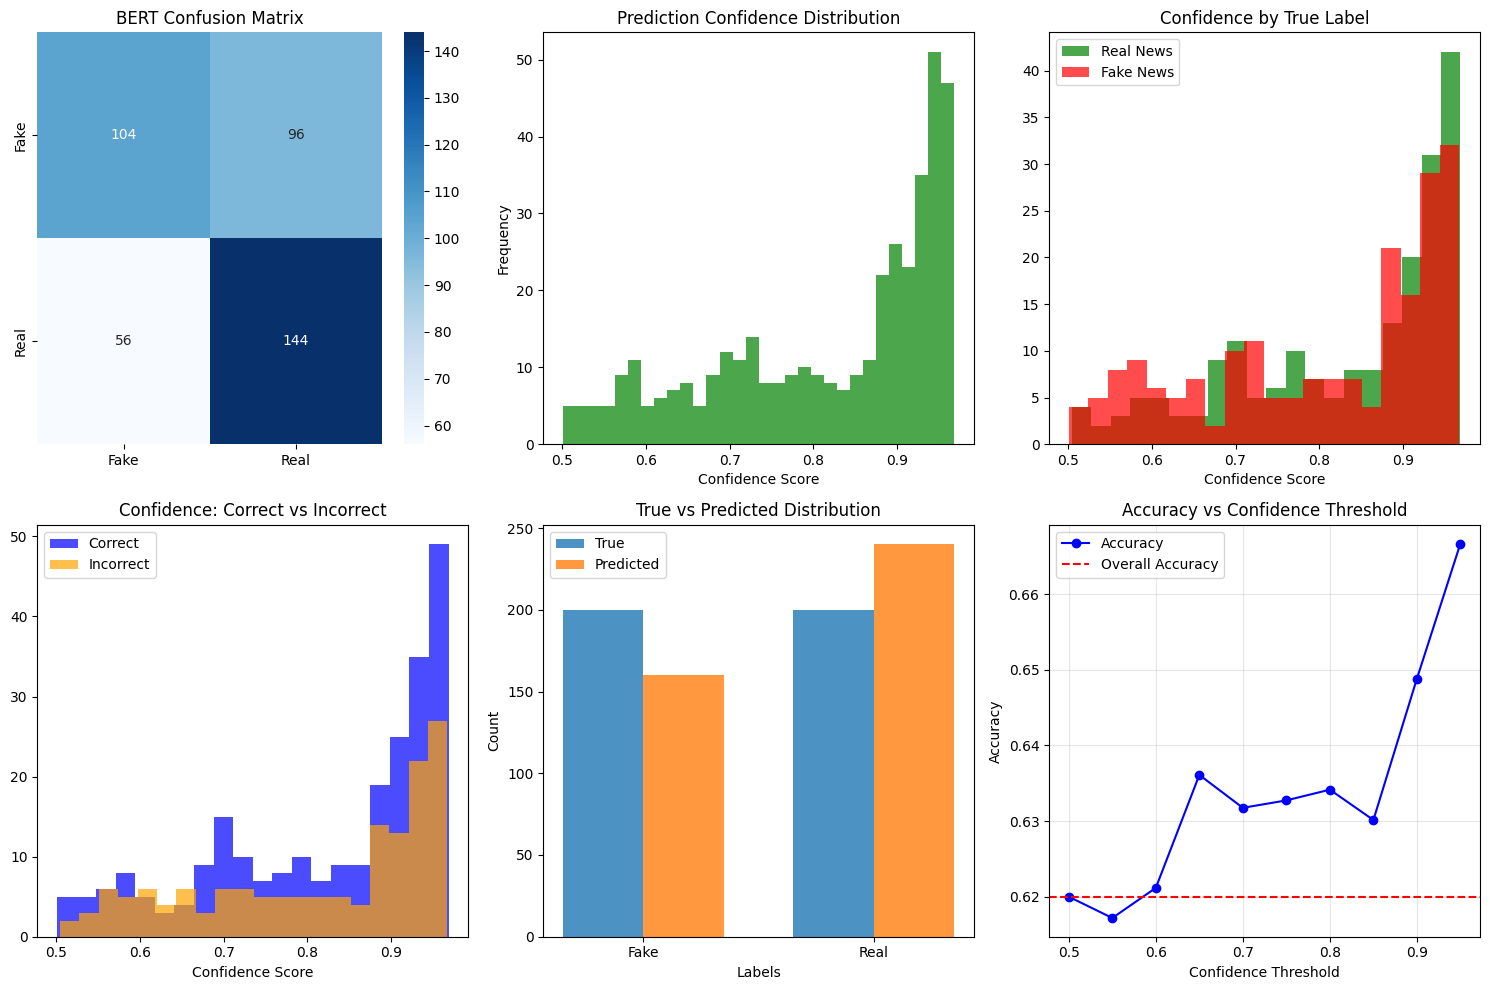

In [12]:
print("\n📊 CREATING VISUALIZATIONS...")

try:
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(test_labels_tensor.cpu().numpy(), bert_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('BERT Confusion Matrix')
    
    # Prediction Confidence Distribution
    plt.subplot(2, 3, 2)
    confidence_scores = np.max(bert_probabilities, axis=1)
    plt.hist(confidence_scores, bins=30, alpha=0.7, color='green')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    
    # Confidence by True Label
    plt.subplot(2, 3, 3)
    true_labels = test_labels_tensor.cpu().numpy()
    real_confidence = confidence_scores[true_labels == 1]
    fake_confidence = confidence_scores[true_labels == 0]
    
    plt.hist(real_confidence, bins=20, alpha=0.7, label='Real News', color='green')
    plt.hist(fake_confidence, bins=20, alpha=0.7, label='Fake News', color='red')
    plt.title('Confidence by True Label')
    plt.xlabel('Confidence Score')
    plt.legend()
    
    # Correct vs Incorrect Predictions
    plt.subplot(2, 3, 4)
    correct_mask = (bert_predictions == true_labels)
    correct_conf = confidence_scores[correct_mask]
    incorrect_conf = confidence_scores[~correct_mask]
    
    plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='blue')
    plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='orange')
    plt.title('Confidence: Correct vs Incorrect')
    plt.xlabel('Confidence Score')
    plt.legend()
    
    # Label Distribution
    plt.subplot(2, 3, 5)
    labels = ['Fake', 'Real']
    true_counts = np.bincount(true_labels)
    pred_counts = np.bincount(bert_predictions)
    
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, true_counts, width, label='True', alpha=0.8)
    plt.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('True vs Predicted Distribution')
    plt.xticks(x, labels)
    plt.legend()
    
    # Performance by Confidence Threshold
    plt.subplot(2, 3, 6)
    thresholds = np.arange(0.5, 1.0, 0.05)
    accuracies = []
    sample_sizes = []
    
    for threshold in thresholds:
        high_conf_mask = confidence_scores >= threshold
        if sum(high_conf_mask) > 0:
            high_conf_acc = accuracy_score(
                true_labels[high_conf_mask], 
                bert_predictions[high_conf_mask]
            )
            accuracies.append(high_conf_acc)
            sample_sizes.append(sum(high_conf_mask))
        else:
            accuracies.append(0)
            sample_sizes.append(0)
    
    plt.plot(thresholds, accuracies, 'b-o', label='Accuracy')
    plt.axhline(y=bert_accuracy, color='r', linestyle='--', label='Overall Accuracy')
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Confidence Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"⚠ Visualization error: {str(e)}")


🔄 COMPARING WITH TF-IDF MODEL...
✅ Model comparison:
   TF-IDF Accuracy: 0.610
   BERT Accuracy:   0.620
   Improvement:     0.010


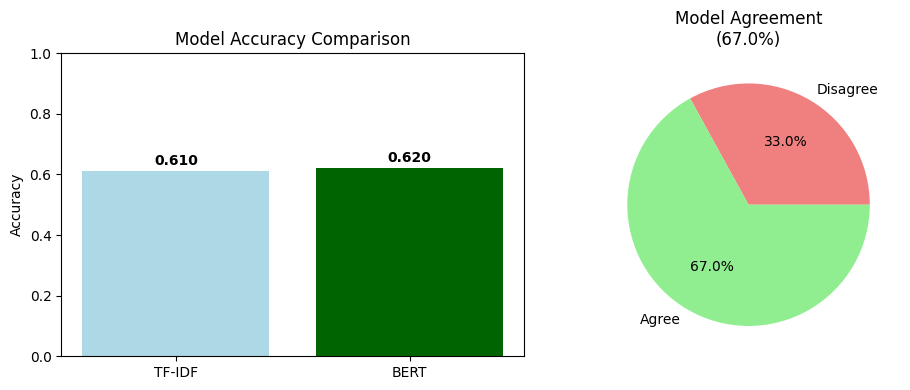

In [20]:
print("\n🔄 COMPARING WITH TF-IDF MODEL...")

try:
    # Load Member 2's TF-IDF model
    tfidf_model = joblib.load('../models/tfidf_model.pkl')
    tfidf_vectorizer = joblib.load('../models/tfidf_vectorizer.pkl')
    
    # Get TF-IDF predictions on same test data
    test_texts_tfidf = test_sample['clean_statement'].fillna('')
    X_test_tfidf = tfidf_vectorizer.transform(test_texts_tfidf)
    tfidf_predictions = tfidf_model.predict(X_test_tfidf)
    tfidf_accuracy = accuracy_score(test_labels_tensor.cpu().numpy(), tfidf_predictions)
    
    print("✅ Model comparison:")
    print(f"   TF-IDF Accuracy: {tfidf_accuracy:.3f}")
    print(f"   BERT Accuracy:   {bert_accuracy:.3f}")
    print(f"   Improvement:     {bert_accuracy - tfidf_accuracy:.3f}")
    
    # Visualization
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    models = ['TF-IDF', 'BERT']
    accuracies = [tfidf_accuracy, bert_accuracy]
    colors = ['lightblue', 'darkgreen']
    
    bars = plt.bar(models, accuracies, color=colors)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(1, 2, 2)
    # Agreement between models
    agreement = (tfidf_predictions == bert_predictions)
    agreement_rate = sum(agreement) / len(agreement)
    
    labels = ['Disagree', 'Agree']
    sizes = [1-agreement_rate, agreement_rate]
    colors = ['lightcoral', 'lightgreen']
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title(f'Model Agreement\n({agreement_rate:.1%})')
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("⚠ TF-IDF model not found. Run Member 2's notebook first for comparison.")
except Exception as e:
    print(f"⚠ Comparison error: {str(e)}")

In [21]:
print("\n🔍 ERROR ANALYSIS...")

try:
    # Find misclassified examples
    true_labels = test_labels_tensor.cpu().numpy()
    incorrect_mask = (bert_predictions != true_labels)
    
    if sum(incorrect_mask) > 0:
        print(f"📊 Found {sum(incorrect_mask)} misclassified examples:")
        
        # Get misclassified examples
        misclassified_indices = np.where(incorrect_mask)[0]
        sample_errors = misclassified_indices[:5]  # Show first 5 errors
        
        print("\n❌ Sample Misclassifications:")
        print("="*80)
        
        for i, idx in enumerate(sample_errors):
            original_idx = test_sample.iloc[idx].name
            statement = test_sample.iloc[idx]['statement']
            true_label = 'Real' if true_labels[idx] == 1 else 'Fake'
            pred_label = 'Real' if bert_predictions[idx] == 1 else 'Fake'
            confidence = np.max(bert_probabilities[idx])
            
            print(f"\n🔍 Error {i+1}:")
            print(f"   Statement: {statement[:100]}...")
            print(f"   True Label: {true_label}")
            print(f"   Predicted: {pred_label}")
            print(f"   Confidence: {confidence:.3f}")
            print(f"   Subject: {test_sample.iloc[idx].get('subject', 'N/A')}")
            print(f"   Party: {test_sample.iloc[idx].get('party', 'N/A')}")
            print("-" * 80)
    
    # Analysis by subject
    test_sample_with_pred = test_sample.copy()
    test_sample_with_pred['bert_prediction'] = bert_predictions
    test_sample_with_pred['correct'] = (bert_predictions == true_labels)
    
    subject_accuracy = test_sample_with_pred.groupby('subject')['correct'].agg(['mean', 'count'])
    subject_accuracy = subject_accuracy[subject_accuracy['count'] >= 5]  # Only subjects with 5+ samples
    subject_accuracy = subject_accuracy.sort_values('mean', ascending=False)
    
    print(f"\n📊 Accuracy by Subject (min 5 samples):")
    print(subject_accuracy.head(10))

except Exception as e:
    print(f"⚠ Error analysis failed: {str(e)}")


🔍 ERROR ANALYSIS...
📊 Found 152 misclassified examples:

❌ Sample Misclassifications:

🔍 Error 1:
   Statement: Sen. Bob Menendez voted to enact a new tax on the sale of homes of 3.8%....
   True Label: Fake
   Predicted: Real
   Confidence: 0.702
   Subject: health-care,housing,income,taxes
   Party: none
--------------------------------------------------------------------------------

🔍 Error 2:
   Statement: Barack Obama's health care plan "will cost taxpayers $1,700 more to cover each new person."...
   True Label: Fake
   Predicted: Real
   Confidence: 0.891
   Subject: health-care
   Party: democrat
--------------------------------------------------------------------------------

🔍 Error 3:
   Statement: What I look at every month is how many more New Jerseyans are back to work. You have another 9,900 l...
   True Label: Fake
   Predicted: Real
   Confidence: 0.951
   Subject: jobs
   Party: republican
-----------------------------------------------------------------------------